# Wilcoxon Signed Rank Test

In [24]:
import os
import json
import pandas as pd
import numpy as np
import scipy
from scipy.stats import wilcoxon
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.float_format = '{:,.3f}'.format


### Try Wilcoxon

In [25]:
d = [6, 8, 14, 16, 23, 24, 28, 29, 41, -48, 49, 56, 60, -67, 75]
d = [6, 8, 14, 16, 23, 24, 28, 29, 41, 49, 56, 60, 75]
w, p = wilcoxon(d, alternative='greater')
w, p = wilcoxon(d)
p

0.000244140625

## Analyze

In [26]:
with open('result/RQ2.json', 'r') as f:
  data = json.load(f)


In [27]:
res = {}

asrs = ["quartznet", "hubert", "wav2vec-base"]
datasets = ["YBAA", "ZHAA", "ASI", "TNI", "NCC",
            "TXHC", "EBVS", "ERMS", "YDCK", "YKWK", "THV", "TLV"]
tools = ["random", "triphone_rich", "pure_diversity", "icassp_without_diversity_enhancing_real_mix", "icassp_real_mix",
         "asrevolve_error_model_real", "word_error_real_mix/no_word_enhance", "word_error_real_mix/word_enhance"]


# asrs = ["quartznet"]
# datasets = ["YBAA", "ZHAA", "ASI", "TNI"]
# tools = ["random", "triphone_rich", "pure_diversity"]

res = {}
for asr in asrs:
    res[asr] = {}
    for dataset in datasets:
        res[asr][dataset] = {}
        for tool in tools:
            res[asr][dataset][tool] = pd.read_csv(data[asr][dataset][tool])
            
# res


In [28]:
short_names = {
    "random": "RND",
    "triphone_rich": "TR",
    "pure_diversity": "PD",
    "icassp_without_diversity_enhancing_real_mix": "IC-WDE",
    "icassp_real_mix": "IC",
    "asrevolve_error_model_real": "ASR-EV",
    "word_error_real_mix/no_word_enhance": "NWE",
    "word_error_real_mix/word_enhance": "WE",
}

In [29]:
def plot_heatmap(metrics, title, cmap, fpath, vmin, vmax, annot=True):

    df = pd.DataFrame(data=metrics)

    plt.figure(figsize=(12, 9))
    fig = sns.heatmap(df, cmap=cmap, vmin=vmin, vmax=vmax,
                      annot=annot, fmt="d", linewidth=0.7)
#     fig.set(xlabel='Test', ylabel='Train', fontsize=18)
    plt.title(title, fontsize=24)
    plt.xlabel('Tool', fontsize=16)
    plt.ylabel('Tool', fontsize=16)
    fig.figure.savefig(fpath, bbox_inches='tight')
    plt.show()


### 1. Analyze the experiment grouped by \<ASR Model\>

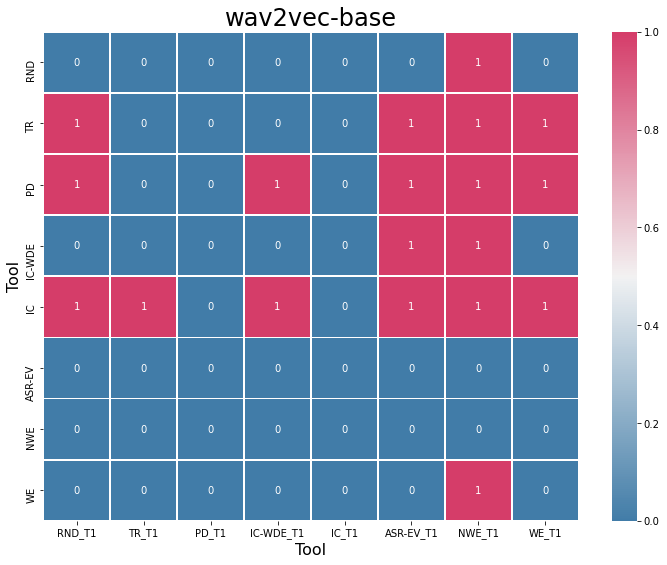

In [32]:
def get_wer_result(df):
    arr = list(df["WER_Seed1"]) + list(df["WER_Seed2"]) + list(df["WER_Seed3"])
    assert len(arr) == 3 * len(df["WER_Seed1"])
    assert len(arr) == 3 * len(df["WER_Seed2"])
    assert len(arr) == 3 * len(df["WER_Seed3"])
    return arr




values = {}
    
for tool_1 in tools:
    values[short_names[tool_1]+"_T1"] = {}
    for tool_2 in tools :

        if tool_1 == tool_2:
            values[short_names[tool_1]+"_T1"][short_names[tool_2]] = 0
        else :
            arr_1 = []
            arr_2 = []
            for asr in asrs:
                for dataset in datasets :
                    arr_1 += get_wer_result(res[asr][dataset][tool_1])
                    arr_2 += get_wer_result(res[asr][dataset][tool_2])

            w, p = scipy.stats.wilcoxon(
                arr_1, arr_2, alternative='less')
            # we would reject the null hypothesis at a confidence level of 5%
            if p < 0.05:
                values[short_names[tool_1]+"_T1"][short_names[tool_2]] = 1
            else :
                values[short_names[tool_1]+"_T1"][short_names[tool_2]] = 0

# print(values)

df = pd.DataFrame(data=values)
# print(df)

os.makedirs("result/plot/", exist_ok=True)
path = f"result/plot/significance_difference_{asr}.png"

# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=0, s=75, l=50, n=1, as_cmap=True)
# plot_heatmap(sorted_acc, cmap, path, 0, 1)
plot_heatmap(df, asr, cmap, path, 0, 1)
            
